In [1]:
"""rmse using transfer UNet (cascade)
current issue: need to change a number in .forward of the UNet code when changing from 
UNet with isotropic cm to UNet with directional cm since the number of input channels 
are different. Temporary solution: run iso_UNet, save the output image, change the .forward 
function's number (2 to 3 or the other way round), restart kernel, run directional UNet. 
"""

import argparse
import logging
import os
import itertools
# some_file.py
import math

import sys

from geopy.distance import distance as geopy_dist 

# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/yl826/3DPathLoss/nc_raytracing/Pytorch-UNet-master')
    
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import numpy as np

from scipy import ndimage, datasets
from scipy.constants import speed_of_light

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms

from PIL import Image

from unet.unet_model_rt import UNet
from utils.utils import plot_img_and_mask

from CBRSUtils import CBRSUtils as cu

import random

from pathlib import Path

from decimal import Decimal
import json
import psycopg2


dir_checkpoint = Path('./checkpoints_PN/')

building_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_building_npy')
terrain_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_terrain_npy')
ground_truth_signal_strength_map_dir = os.path.abspath('/dev/shm/coverage_maps_data_aug_Jul18/')
sparse_ss_dir = Path('/home/yl826/3DPathLoss/nc_raytracing/jul18_sparse')

b_map_path_dict = {6: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              7: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              3: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              4: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              20: "/home/yl826/3DPathLoss/nc_raytracing/POC/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy",
              40: "/home/yl826/3DPathLoss/nc_raytracing/POC/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy"}
name_dict = {6: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              7: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              3: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              4: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              20: "0_78d03890-be26-47f8-8b81-8485f0d19a83.npy",
              40: "0_78d03890-be26-47f8-8b81-8485f0d19a83.npy"}

# lat lon pairs, antenna location
PCI6_7_3_4_center = (35.999186254897836, -78.9397858960648)
PCI20_40_center = (36.00307128210248, -78.93706070613855)

lat_lon_center_dict = {6: PCI6_7_3_4_center,
                        7: PCI6_7_3_4_center,
                        3: PCI6_7_3_4_center,
                        4: PCI6_7_3_4_center,
                        20: PCI20_40_center,
                        40: PCI20_40_center}

PCI6_7_3_4_top_left = (36.001483241320656, -78.94273733701348)
PCI20_40_top_left = (36.005429554748495, -78.93998431793196)
lat_lon_top_left_dict = {6: PCI6_7_3_4_top_left,
                         7: PCI6_7_3_4_top_left,
                         3: PCI6_7_3_4_top_left,
                         4: PCI6_7_3_4_top_left,
                         20: PCI20_40_top_left, 
                         40: PCI20_40_top_left}  # lat, lon pairs for top left corner

which_PCI = 3  # these values are possible: 20, 40, 6, 7, 3, 4
save_iso_output_name = 'PCI=%d_iso_UNet_out' % (which_PCI)

print(lat_lon_top_left_dict)

{6: (36.001483241320656, -78.94273733701348), 7: (36.001483241320656, -78.94273733701348), 3: (36.001483241320656, -78.94273733701348), 4: (36.001483241320656, -78.94273733701348), 20: (36.005429554748495, -78.93998431793196), 40: (36.005429554748495, -78.93998431793196)}


In [2]:
def rows_to_dict(rowsss, cccursor):
    columns = [desc[0] for desc in cccursor.description]
    result = []
    for rrr in rowsss:
        result.append(dict(zip(columns, rrr)))
    return result


def combine_dicts_to_dict_of_lists(dict_list):
    result = {}
    for dictionary in dict_list:
        for key, value in dictionary.items():
            if key not in result:
                result[key] = []
            result[key].append(value)
    for key in result.keys():
        if isinstance(result[key][0], Decimal):
            for iii, item in enumerate(result[key]):
                result[key][iii] = float(item)
    return result


def get_data_dict():
    connection = psycopg2.connect(database=db_name, user=db_user,
                                  password=db_password, host=db_host, port=db_port)
    cursor = connection.cursor()

    cursor.execute(f"SELECT latitude as latitude, longitude as longitude, "
                   "rsrp as rsrp, azimuth as azimuth FROM \"SigCapDetails\" "
                   # "WHERE (\"mPci\"=40 or \"mPci\"=40) and (\"operatorID\" "
                   "WHERE \"mPci\"=" + str(which_PCI) + " and (\"operatorID\" "
                   "like \'runxi%\' or \"operatorID\" like \'Taro%\')")
    print(which_PCI)
    rows = cursor.fetchall()

    df_ret = combine_dicts_to_dict_of_lists(rows_to_dict(rows, cursor))
    cursor.close()
    connection.close()
    return df_ret


with open("SQLpwd.json", 'r') as file:
    credential = json.load(file)
db_host = credential['db_host']
db_port = credential['db_port']
db_name = credential['db_name']
db_user = credential['db_user']
db_password = credential['db_password']

df_SigCapDetails = get_data_dict()
print(df_SigCapDetails['azimuth'][0:5])
print(df_SigCapDetails['latitude'][0:5])
print(df_SigCapDetails['longitude'][0:5])
print(len(df_SigCapDetails["azimuth"]))
print((df_SigCapDetails['rsrp'][::100]))

3
[66.22511121128261, 125.22405986561013, 83.03246506044563, 156.02855453182613, 117.634435622162]
[35.99882108, 35.99900485, 35.99879743, 35.99946644, 35.99828771]
[-78.94065134, -78.94053627, -78.94067238, -78.94020179, -78.93973152]
1850
[-80, -82, -86, -82, -93, -125, -113, -95, -122, -125, -84, -101, -111, -101, -135, -86, -83, -115, -110]


In [3]:
# 3.Load data
# first, get idx_uuid.npy (building map name)
name = name_dict[which_PCI]

name_splited = name.split("_")
file_name_id_part = name_splited[0]  # idxuuid
tx_height = 24
tx_x = 256
tx_y = 256
tx_position = [tx_x // 4, tx_y // 4]
distance = np.arange(0, 1450, 1)

# lookup table for path_loss_res, resolution=1 meter
path_loss_res =  cu.pathloss_38901(distance,3.64, h_bs=int(tx_height), h_ut=2)

# load building map and downsample
building_height_ori = np.load(b_map_path_dict[which_PCI])
building_height_ori = building_height_ori[0:512, 0:512]
building_height_arr = building_height_ori[::4, ::4]

# generate list of tuples of (numpy_row, numpy_col, rsrp) by converting lat,lon into 
# local coordinates. 'list of tuples' is represented by np.array
measurement = np.empty([len(df_SigCapDetails["latitude"]), 3])
measurement[:, 0] = df_SigCapDetails["latitude"]
measurement[:, 1] = df_SigCapDetails["longitude"]
measurement[:, 2] = df_SigCapDetails["rsrp"]

for idx, point in enumerate(measurement):
    row, col = cu.gps2local(measurement[idx,0], measurement[idx,1], 
                            top_left_latitude=lat_lon_top_left_dict[which_PCI][0],
                            top_left_longitude=lat_lon_top_left_dict[which_PCI][1])
    measurement[idx, 0] = row
    measurement[idx, 1] = col

# get sparse_ss
ground_truth_list, sparse_ss_arr = np.split(np.random.default_rng(seed=42).permutation(measurement), [len(measurement)-200])
ground_truth_list = measurement

sparse_ss_arr[:, 0] = sparse_ss_arr[:, 0]/4.0
sparse_ss_arr[:, 1] = sparse_ss_arr[:, 1]/4.0

increment_permutations = np.array(list(itertools.permutations([-1, 0, 1]))).reshape(-1, 1)

def col_row_for_no_building(row_, col_, bh_arr=building_height_arr, 
                            increment=increment_permutations):
    """
    :param row_: index that has height != 0
    :param col_: index that has height != 0
    :param bh_arr: building height array
    :param increment: tuples for incrementing [row,col]
    """
    for iii in range(3):
        for jjj in range(3):
            try: 
                height_ = bh_arr[row_+increment[2*iii][jjj], col_+increment[2*iii+1][jjj]]
            except IndexError:
                continue
            if height_ == 0:
                return row_+increment[2*iii][jjj], col_+increment[2*iii+1][jjj]
    # cannot find no building area in 3x3 region
    return None, None

print("# of points for point-net: ", len(sparse_ss_arr))
print("# of points for ground_truth: ", len(ground_truth_list))

ground_truth_tmp =  np.empty((128, 128), dtype=object)
count_num_no_building = 0
for point in ground_truth_list:
    row = int(point[0]/4)
    col = int(point[1]/4)
    if row >=128 or col >= 128 or row < 0 or col < 0:
        continue
    if building_height_arr[row,col] != 0:
        row, col = col_row_for_no_building(row, col)  # attempts to update row, col 
        if row is None or col is None:  # didn't find good row, col
            count_num_no_building += 1
            continue
    if ground_truth_tmp[row, col] is None:
        ground_truth_tmp[row, col] = np.array(point[2])
    else:
        ground_truth_tmp[row][col] = np.append(ground_truth_tmp[row][col], point[2])
        

print("number of points where there's a building", count_num_no_building)
ground_truth_arr = np.empty((128, 128))
for row in range(128):
    for col in range(128):
        if ground_truth_tmp[row, col] is None:
            ground_truth_arr[row][col] = -160
            
        else:
            ground_truth_arr[row][col] = ground_truth_tmp[row,col].mean()
            ground_truth_arr[row][col] = np.median(ground_truth_tmp[row,col])
            ground_truth_arr[row][col] = 10 * np.log10( ( 10 ** ( ground_truth_tmp[row,col]/ 10)  ).mean() )

 # Construct the TX position channel
tx_position_channel = np.full((128, 128), 0, dtype=int)
tx_position_channel[tx_position[1]][tx_position[0]] = tx_height


path_loss_heat_map = np.full((128, 128), 0, dtype=float)



for row in range(path_loss_heat_map.shape[0]):
    for col in range(path_loss_heat_map.shape[1]):
        # Compute the distance between pixel and tx
        dist = math.sqrt((tx_position[1]*4 - row*4)**2 + (tx_position[0]*4 - col*4)**2)
        path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]

# of poitn for point-net:  200
# of poitn for ground_truth:  1850
number of points where there's a building 7


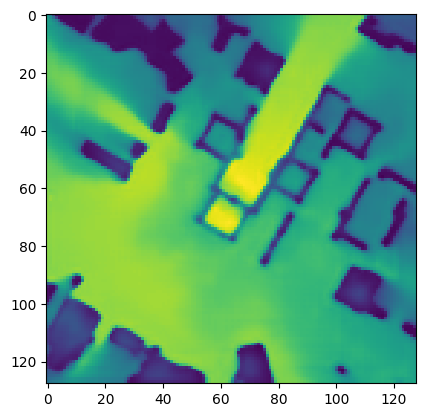

In [8]:
#### net for isotropic antenna


net_iso = UNet(n_channels=2, n_classes=1, bilinear=False, pathloss=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_iso.to(device=device)


# 2.Load state dict
state_dict = torch.load("../Pytorch-UNet-master/checkpoints/checkpoint_epoch58.pth", map_location=device)
net_iso.load_state_dict(state_dict)


# Since right now GT.size is 100*100 and other two size is 1000 * 1000, just check the input.
# assert building_height_arr.shape == terrain_height_aimport loggin
combined_input = np.zeros((3, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = building_height_arr 
combined_input[1,:, :] = tx_position_channel
combined_input[2,:, :] = path_loss_heat_map

batch = {
            'combined_input': torch.as_tensor(combined_input.copy()).float().contiguous(),
            'ground_truth': torch.as_tensor(ground_truth_arr.copy()).long().contiguous(),
            'file_name': name,
            'sparse_ss': torch.as_tensor(sparse_ss_arr.copy()).float().contiguous()
        }


# Eval
images, ground_truth = batch['combined_input'], batch['ground_truth']
sparse_ss = batch['sparse_ss']

# Since we directly load the data by manual, add batch dimension to the front of data
images = images[None,:, :, :]
sparse_ss = sparse_ss[None,:, :]


net_iso.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
ground_truth = ground_truth.to(device=device, dtype=torch.long)
sparse_ss = sparse_ss.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net_iso(images, sparse_ss).cpu()

output_iso_UNet = output.squeeze().cpu().numpy()
plt.imshow(output_iso_UNet, interpolation='none')

np.save(save_iso_output_name, output_iso_UNet)

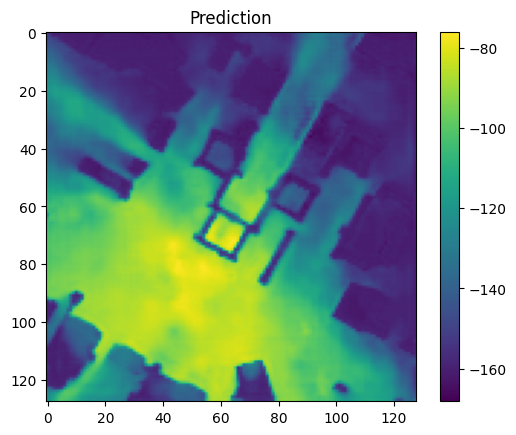

/home/yl826/3DPathLoss/nc_raytracing/POC/CBRSUtils.py:128: RuntimeWarning: divide by zero encountered in log10
  return 32.45 + 20 * np.log10(d) + 20 * np.log10(f)


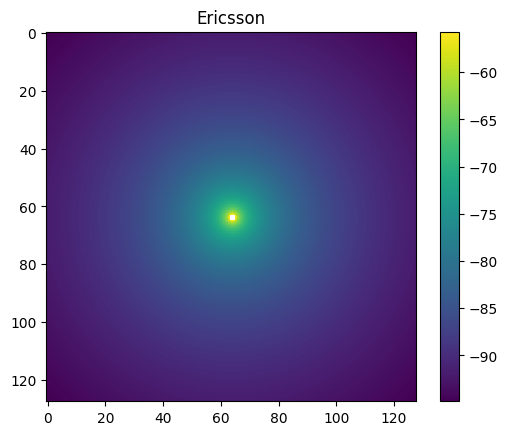

/home/yl826/3DPathLoss/nc_raytracing/POC/CBRSUtils.py:149: RuntimeWarning: divide by zero encountered in log10
  line1 = a0 + a1 * np.log10(d) + a2 * np.log10(h_b)
/home/yl826/3DPathLoss/nc_raytracing/POC/CBRSUtils.py:150: RuntimeWarning: divide by zero encountered in log10
  line2 = + a3 * np.log10(h_b) * np.log10(d)


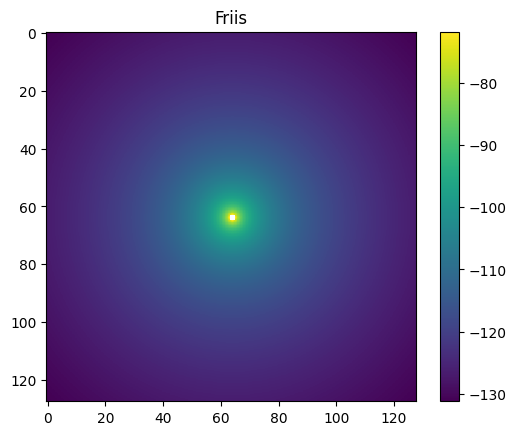


++++++++++++++ Ericsson ++++++++++++++
score 0.01330389187723413
coef 0.5338514137552742
intercept -50.51616130957003
rmse  18.868876578678012
rmse after linear regression  14.801538145650392
mae  13.94233382459571
mae after linear regression  14.801538145650392


++++++++++++++ friis ++++++++++++++
score 0.01330389187723413
coef 0.35193555411558436
intercept -54.98469313982211
rmse  25.691379755305235
rmse after linear regression  14.801538145650392
mae  22.004046435015418
mae after linear regression  14.801538145650392


++++++++++++++ ML ++++++++++++++
original without fitting rmse  5.2216923769836585


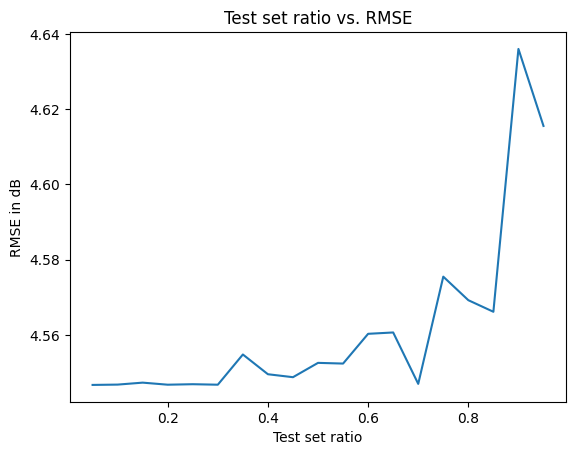


++++++++++++++ PL ++++++++++++++
original without fitting rmse  19.312137835809914


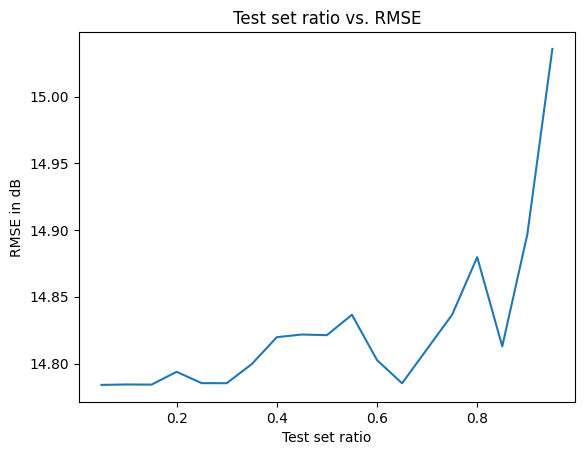

In [5]:
# UNet for tr38901

# 1.Create the Model
net = UNet(n_channels=3, n_classes=1, bilinear=False, pathloss=False)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
net.to(device=device)


# 2.Load state dict
#state_dict = torch.load("../Pytorch-UNet-master/checkpoints_transfer/checkpoint_epoch21.pth", map_location=device)
state_dict = torch.load("../Pytorch-UNet-master/checkpoints_transfer_backup_cascade/checkpoint_epoch120.pth", map_location=device)

net.load_state_dict(state_dict)




# Since right now GT.size is 100*100 and other two size is 1000 * 1000, just check the input.
# assert building_height_arr.shape == terrain_height_aimport loggin
combined_input = np.zeros((3, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = building_height_arr
ss_map = np.full((128, 128), -160)

res = []
ss_map = np.full((128, 128), -160)
count = 0
while count < 200:
    xx = random.randint(0, 127)
    yy = random.randint(0, 127)
    if ground_truth_arr[xx][yy] != -160 and ss_map[xx][yy] == -160:
        count+=1
        ss_map[xx][yy] = ground_truth_arr[xx][yy]

combined_input[1,:, :] = ss_map
plt.imshow(ss_map)
plt.colorbar()
plt.close()
combined_input[2,:, :] = np.load(save_iso_output_name + '.npy') 
# combined_input[2,:, :] = output_iso_UNet

batch = {
            'combined_input': torch.as_tensor(combined_input.copy()).float().contiguous(),
            'ground_truth': torch.as_tensor(ground_truth_arr.copy()).long().contiguous(),
            'file_name': name,
            'sparse_ss': torch.as_tensor(sparse_ss_arr.copy()).float().contiguous()
        }




# 4. Eval
images, ground_truth = batch['combined_input'], batch['ground_truth']
sparse_ss = batch['sparse_ss']

# Since we directly load the data by manual, add batch dimension to the front of data
images = images[None,:, :, :]
sparse_ss = sparse_ss[None,:, :]


net.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
ground_truth = ground_truth.to(device=device, dtype=torch.long)
sparse_ss = sparse_ss.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(images, sparse_ss).cpu()

output = output.squeeze().cpu().numpy()

plt.imshow(output)
plt.title("Prediction")
plt.colorbar()
plt.show()



def generate_pathloss_heatmap(model_name, h_bs, h_ut, freq, shape, tx_position):
    model_dict = {
    "ericsson": cu.pathloss_friis_free_space_model,
    "friis": cu.pathloss_ericsson_model,
    }
    
    func = model_dict.get(model_name, None)
    assert func is not None, "Model name not found! Try ericsson or friis"
    assert freq > 10, "Freq in MHz! Not GHz"
    
    
    path_loss_heat_map = np.full(shape, 0, dtype=float)
    
    for row in range(path_loss_heat_map.shape[0]):
        for col in range(path_loss_heat_map.shape[1]):
            
            dist = math.sqrt((tx_position[0]*4 - row*4)**2 + (tx_position[1]*4 - col*4)**2)
            
            path_loss_heat_map[row][col] =  -1 * func(dist/1000, h_bs, h_ut, freq )
    return path_loss_heat_map
ericsson_pl = generate_pathloss_heatmap("ericsson",int(tx_height), 2, 3640, output.shape, tx_position )
plt.imshow(ericsson_pl)
plt.title("Ericsson")
plt.colorbar()
plt.show()

friis_pl = generate_pathloss_heatmap("friis",int(tx_height), 2, 3640, output.shape, tx_position )
plt.imshow(friis_pl)
plt.title("Friis")
plt.colorbar()
plt.show()

ericsson_coef, ericsson_intercept, ericsson_ori_rmse, ericsson_fitted_rmse = cu.generate_linear_regression_result(ericsson_pl,ground_truth_arr,"Ericsson")
friis_coef, friis_intercept, friis_ori_rmse, friis_fitted_rmse = cu.generate_linear_regression_result(friis_pl,ground_truth_arr,"friis")



def generate_linear_regression_result(prediction, ground_truth, title="", print_result=True):
    """
    :param prediction:  predicted value
    :param ground_truth: ground truth value
    :param title:
    :param print_result:
    :return:
    """
    assert ground_truth.shape == prediction.shape, "ground_truth and prediction shape mismatch "
    print()
    print("++++++++++++++", title, "++++++++++++++")
    X = []
    y = []
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[1]):
            if ground_truth[row, col] != -160:
                X.append(prediction[row, col])
                y.append(ground_truth[row, col])
    X = np.array(X).reshape(-1, 1)
    tmp_res = []
    tmp_x = np.arange(0.05,1.0,0.05)
    ori_rmse = mean_squared_error(y, X, squared=False)
    print("original without fitting rmse ", ori_rmse)
    for i in np.arange(0.05,1.0,0.05):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 42)
        reg = LinearRegression().fit(X_train, y_train)

#         print("score", reg.score(X, y))
#         print("coef", reg.coef_[0])

#         print("intercept", reg.intercept_)

        ori_rmse = mean_squared_error(y, X, squared=False)
        # print("rmse ", ori_rmse)

        fitted_rmse = mean_squared_error(y, X * reg.coef_ + reg.intercept_, squared=False)
        # print("rmse after linear regression ", fitted_rmse)

        ori_mae = mean_absolute_error(y, X)
        fitted_mae = mean_absolute_error(y, X * reg.coef_ + reg.intercept_)
        # print("mae ", ori_mae)
        # print("mae after linear regression ", fitted_rmse)
        tmp_res.append(fitted_rmse)
    plt.plot(tmp_x, tmp_res)
    plt.title("Test set ratio vs. RMSE")
    plt.xlabel('Test set ratio')
    plt.ylabel('RMSE in dB')
    plt.show()
    return reg.coef_[0], reg.intercept_, ori_rmse, fitted_mae
    
ml_coef, ml_intercept, ml_ori_rmse, ml_fitted_rmse = generate_linear_regression_result(output,ground_truth_arr,"ML")
pl_coef, pl_intercept, pl_ori_rmse, pl_fitted_rmse = generate_linear_regression_result(path_loss_heat_map,ground_truth_arr,"PL")

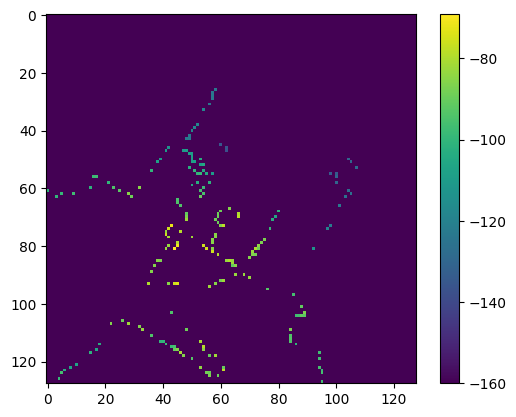

In [6]:
plt.imshow(ss_map, interpolation='none')
plt.colorbar()

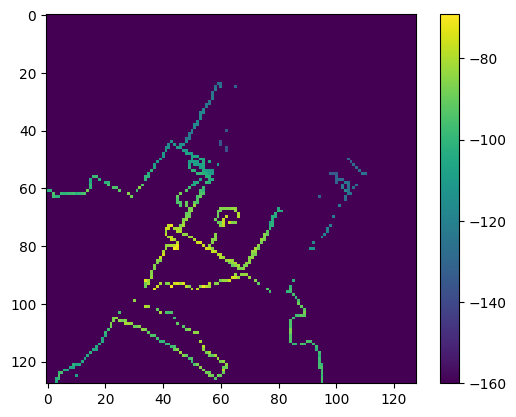

In [7]:
plt.imshow(ground_truth_arr, interpolation='none')
plt.colorbar()

In [ ]:
cu.gps2local(36.00247804455967, -78.94120458940182)